# Southern Ocean Flux Station Mooring

**Project** 
Integrated Marine Observing System (IMOS)

**Title** Heat, mass and momentum flux data from Southern Ocean Flux Station

**Institution** Australian Bureau of Meteorology

**Abstract**
SOFS is a moored ocean buoy in the Sub-Antarctic Zone, approximately 350 nautical miles southwest of Tasmania. It obtains frequent measurements of the near-surface atmospheric and ocean properties. The observations are used to calculate bulk fluxes of heat, mass and momentum.

**Comment_flux_calculation** COARE Bulk Flux Algorithm version 3.5 (Fairall, C.W., E.F. Bradley, J.E. Hare, A.A. Grachev, and J.B. Edson (2003), Bulk parameterization of air sea fluxes: updates and verification for the COARE algorithm, J. Climate, 16, 571-590.) with modification based on the CLIMODE, MBL and CBLAST experiments (Edson et al., 2012). Net heat flux does not include flux due to a rainfall (H_RAIN). Cool skin calculation on. Warm layer calculation on. Wave dependence parameterisation off. Atmospheric boundary layer depth zi set to 600m

**Source: Mooring observation: Southern Ocean Flux Station**

**References** http://www.imos.org.au

**Data_centre** Australian Ocean Data Network (AODN)

**Author_email** eric.schulz@bom.gov.au

**Author** Schulz, Eric

**Acknowledgement** Any users (including re-packagers) of IMOS data are required to clearly acknowledge the source of the material in this format: "Data was sourced from the Integrated Marine Observing System (IMOS) - IMOS is supported by the Australian Government through the National Collaborative Research Infrastructure Strategy and the Super Science Initiative."

**License** http://creativecommons.org/licenses/by/4.0/


#### Load in the Python modules that we need for this analysis

In [10]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### SOFS CO2 mooring data

**Data curator: Elizabeth Shadwick, CSIRO**

SOFS mooring air sea fluxes are in the MATLAB format .mat file `complete_SOFS_data.mat`, within the structure "mooring_data", table "CO2".

The structure "raw_data" contains the SOFS mooring windspeed and air temperature data, at an hourly resolution, more frequent than the pCO2 measurements.

The MATLAB script `FCO2_CWE.m` calculates the air sea fluxes.

The Matlab mat file "ERA5_SOFS_data.mat" has all the ERA5 data in it. There are data gaps in the SOFS mooring windspeed data that are at times multiple 
days, or weeks. So I patched any data gaps beyond 2h with ERA5. This can be changed if you want less ERA5 data and simply use the nearest in time mooring
observation.

In [129]:
# import the carbon flux and mooring data from the sofs mooring

data_path = '/Users/xduplm/Google Drive/My Drive/data/SOFS/'
data_file = 'co2_data.csv'

df = pd.read_csv(data_path + data_file)

In [130]:
# co2 metadata

# MooringName: Metadata for mooring location and other
# Latitude: Latitude of the mooring in degrees North
# Longitude: Longitude of the mooring in degrees East
# Date: Date in MM/DD/YYYY format
# Time: Time of day (UTC or local time)
# xCO2SW_wet__umol_mol_: Wet molar fraction of carbon dioxide (CO2) in seawater
# CO2SWQF: Quality flag for CO2 seawater measurements
# H2OSW_mmol_mol_: Molar fraction of water vapor in seawater
# xCO2Air_wet__umol_mol_: Wet molar fraction of CO2 in air
# CO2AirQF: Quality flag for CO2 air measurements
# H2OAir_mmol_mol_: Molar fraction of water vapor in air
# LicorAtmPressure_hPa_: Atmospheric pressure measured by Licor instrument in hectopascals
# LicorTemp_C_: Temperature measured by Licor instrument in degrees Celsius
# MAPCO2_O2: Concentration of CO2 in the air (not specified whether it's wet or dry)
# SST_C_: Sea surface temperature in degrees Celsius
# Salinity: Salinity of seawater
# xCO2SW_dry__umol_mol_: Dry molar fraction of CO2 in seawater
# xCO2Air_dry__umol_mol_: Dry molar fraction of CO2 in air
# fCO2SW_sat_Uatm: Saturation of CO2 in seawater in microatmospheres
# fCO2Air_sat_Uatm: Saturation of CO2 in air in microatmospheres
# dfCO2: Difference in molar fraction of CO2 between seawater and air
# pCO2SW_sat_Uatm: Partial pressure of CO2 in seawater at saturation in microatmospheres
# pCO2Air_sat_Uatm: Partial pressure of CO2 in air at saturation in microatmospheres
# dpCO2: Difference in partial pressure of CO2 between seawater and air
# DateTime: Date and time (not clear if it's wind speed related)
# wsp: Wind speed
# wsp_time: Time of wind speed measurement
# wsp_lat: Latitude of wind speed measurement
# wsp_lon: Longitude of wind speed measurement
# wsp_airtemp: Air temperature at the time of wind speed measurement
# ERA5_wsp: Wind speed from ERA5 dataset
# ERA5_time: Time of ERA5 dataset measurement
# ERA5_lat: Latitude of ERA5 dataset measurement
# ERA5_lon: Longitude of ERA5 dataset measurement
# ERA5_airtemp: Air temperature from ERA5 dataset
# flux_mmol_m2_d1: Flux of CO2 in millimoles per square meter per day
# flux_mol_m2_y1: Flux of CO2 in moles per square meter per year

In [131]:
for t in tqdm(range(df.Time.size)):

    if df['Date'][t] == 'NaT':
        continue

    date = df.iloc[t, df.columns.get_loc('Date')] 

    year = date[6:10]

    corr_date = date[:6] + '20' + year[2:]
                                   
    df.iloc[t, df.columns.get_loc('Date')] = corr_date 

  0%|          | 0/13844 [00:00<?, ?it/s]

In [132]:
for t in tqdm(range(df.Time.size)):
    
    if df['Date'][t] == 'NaT':
        df.iloc[t, df.columns.get_loc('Date')] = np.NaN
    
    else:
    # Convert the combined date and time string to datetime and assign it to the array
        df.iloc[t, df.columns.get_loc('Date')] = pd.to_datetime(df['Date'][t] + ' ' + df['Time'][t])

  0%|          | 0/13844 [00:00<?, ?it/s]

#### SOFS mooring heat flux data

In [5]:
import netCDF4
from tqdm.notebook import tqdm

In [6]:
# remove known warnings 

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
from siphon.catalog import TDSCatalog

files = [        
        'IMOS_DWM-SOTS_CFMST_20100317_SOFS_FV02_SOFS-1-2010-Surface-Heat-Flux_END-20110313_C-20171206.nc',
        'IMOS_DWM-ASFS_CFMST_20111125T010000Z_SOFS_FV02_SOFS-2-2011_END-20120722T220000Z_C-20180716T045304Z.nc', 
        'IMOS_DWM-ASFS_CFMST_20120714T080000Z_SOFS_FV02_SOFS-3-2012_END-20130102T000000Z_C-20180716T064518Z.nc', 
        'IMOS_DWM-ASFS_CFMST_20130501T090000Z_SOFS_FV02_SOFS-4-2013-Surface-Flux_END-20131014T195400Z_C-20180716T072641Z.nc', 
        'IMOS_DWM-ASFS_CFMST_20150324T023500Z_SOFS_FV02_SOFS-5-2015_END-20160413T201700Z_C-20180716T055536Z.nc', 
        'IMOS_DWM-SOTS_CFMST_20160316_FluxPulse_FV02_FluxPulse-1-2016-Surface-Heat-Flux_END-20160623_C-20170512.nc', 
        'IMOS_DWM-ASFS_CFMST_20170319T220000Z_SOFS_FV02_SOFS-6-2017_END-20171108T000000Z_C-20180716T025730Z.nc', 
        'IMOS_DWM-SOTS_CFMST_20180822Z_SOFS_FV02_SOFS-7_5-2018-Surface-Flux_END-20190322Z_C-20210424Z.nc', 
        'IMOS_DWM-SOTS_CFMST_20190318Z_SOFS_FV02_SOFS-8-2019-Surface-Flux_END-20200428Z_C-20220511Z.nc', 
        'IMOS_DWM-SOTS_CFMST_20200901Z_SOFS_FV02_SOFS-9-2020-Surface-Flux_END-20210424Z_C-20220510Z.nc', 
        'IMOS_DWM-SOTS_CFMST_20210420Z_SOFS_FV02_SOFS-10-2021-Surface-Flux_END-20220512Z_C-20230516Z.nc'
        ]

years1 = np.arange(2010, 2014, 1)
years2 = np.arange(2015, 2022, 1)

years = np.concatenate([years1, years2])

for i, year in tqdm(enumerate(years)):

    print(str(year), str(files[i]))

    # Construct THREDDS catalog URL for the specific year and month
    catalog_url = f'https://thredds.aodn.org.au/thredds/catalog/IMOS/DWM/SOTS/{year}/catalog.html'

    # Create a TDSCatalog object for the catalog URL
    cat = TDSCatalog(catalog_url)

    dataset = cat.datasets[files[i]]

    # Access the dataset URL
    dataset_url = dataset.access_urls['OPENDAP']

    # Open the dataset using xarray
    ds = xr.open_dataset(dataset_url)

    if i==0:
        ds_sofs = ds.copy()

    else: 
        ds_sofs = xr.concat([ds_sofs, ds], dim='TIME')


0it [00:00, ?it/s]

2010 IMOS_DWM-SOTS_CFMST_20100317_SOFS_FV02_SOFS-1-2010-Surface-Heat-Flux_END-20110313_C-20171206.nc
2011 IMOS_DWM-ASFS_CFMST_20111125T010000Z_SOFS_FV02_SOFS-2-2011_END-20120722T220000Z_C-20180716T045304Z.nc
2012 IMOS_DWM-ASFS_CFMST_20120714T080000Z_SOFS_FV02_SOFS-3-2012_END-20130102T000000Z_C-20180716T064518Z.nc
2013 IMOS_DWM-ASFS_CFMST_20130501T090000Z_SOFS_FV02_SOFS-4-2013-Surface-Flux_END-20131014T195400Z_C-20180716T072641Z.nc
2015 IMOS_DWM-ASFS_CFMST_20150324T023500Z_SOFS_FV02_SOFS-5-2015_END-20160413T201700Z_C-20180716T055536Z.nc
2016 IMOS_DWM-SOTS_CFMST_20160316_FluxPulse_FV02_FluxPulse-1-2016-Surface-Heat-Flux_END-20160623_C-20170512.nc
2017 IMOS_DWM-ASFS_CFMST_20170319T220000Z_SOFS_FV02_SOFS-6-2017_END-20171108T000000Z_C-20180716T025730Z.nc
2018 IMOS_DWM-SOTS_CFMST_20180822Z_SOFS_FV02_SOFS-7_5-2018-Surface-Flux_END-20190322Z_C-20210424Z.nc
2019 IMOS_DWM-SOTS_CFMST_20190318Z_SOFS_FV02_SOFS-8-2019-Surface-Flux_END-20200428Z_C-20220511Z.nc
2020 IMOS_DWM-SOTS_CFMST_20200901Z_SOFS_

In [8]:
ds_sofs

<xarray.Dataset>
Dimensions:            (TIME: 4162060, h_num: 15)
Coordinates:
  * TIME               (TIME) datetime64[ns] 2010-03-17T11:59:00.000003584 .....
    LATITUDE           (TIME) float64 -46.76 -46.76 -46.76 ... -47.0 -47.0 -47.0
    LONGITUDE          (TIME) float64 142.1 142.1 142.1 ... 142.3 142.3 142.3
    NOMINAL_DEPTH      float32 0.0
Dimensions without coordinates: h_num
Data variables: (12/58)
    PL_CMP             (TIME) float32 256.4 309.8 307.1 343.7 ... nan nan nan
    WDIR               (TIME) float32 114.4 109.7 123.9 ... 309.1 309.1 309.1
    WSPD               (TIME) float32 9.5 8.8 9.0 8.7 9.2 ... 6.2 6.2 6.2 6.2
    WIND_H             (TIME) float32 3.52 3.52 3.52 3.52 ... nan nan nan nan
    WIND_FLAG          (TIME) float32 2.0 1.0 2.0 2.0 2.0 ... nan nan nan nan
    ATMP               (TIME) float32 1.021e+03 1.021e+03 ... 1.015e+03
    ...                 ...
    RAIN_AMOUNT_SN     (TIME) float32 nan nan nan nan ... 227.0 227.0 227.0
    RELH_SN            (TIME) float32 nan nan nan nan ... 366.0 366.0 366.0
    SW_SN              (TIME) float32 nan nan nan nan ... 356.0 356.0 356.0
    TEMP_SN            (TIME) float32 nan nan nan ... 1.573e+04 1.573e+04
    WDIR_WSPD_H        (TIME) float32 nan nan nan nan ... 3.156 3.156 3.156
    WDIR_WSPD_SN       (TIME) float32 nan nan nan nan ... 272.0 272.0 272.0
Attributes: (12/58)
    project:                          Integrated Marine Observing System (IMOS)
    title:                            Heat and radiative flux data from South...
    institution:                      Australian Bureau of Meteorology
    date_created:                     2012-07-03T04:12:57Z
    abstract:                         SOFS is an observing platform in the Su...
    comment:                          COARE Bulk Flux Algorithm version 3.0b ...
    ...                               ...
    compliance_checks_passed:         cf imos:1.4
    compliance_checker_version:       2.3.1
    compliance_checker_imos_version:  1.1.3
    DODS.strlen:                      236
    DODS.dimName:                     h_string
    DODS_EXTRA.Unlimited_Dimension:   TIME

In [137]:
df.Date.astype('datetime64[ns]')

0       2011-11-24 09:47:00
1       2011-11-24 10:17:00
2       2011-11-24 10:47:00
3       2011-11-24 11:17:00
4       2011-11-24 11:47:00
                ...        
13839                   NaT
13840                   NaT
13841                   NaT
13842                   NaT
13843                   NaT
Name: Date, Length: 13844, dtype: datetime64[ns]

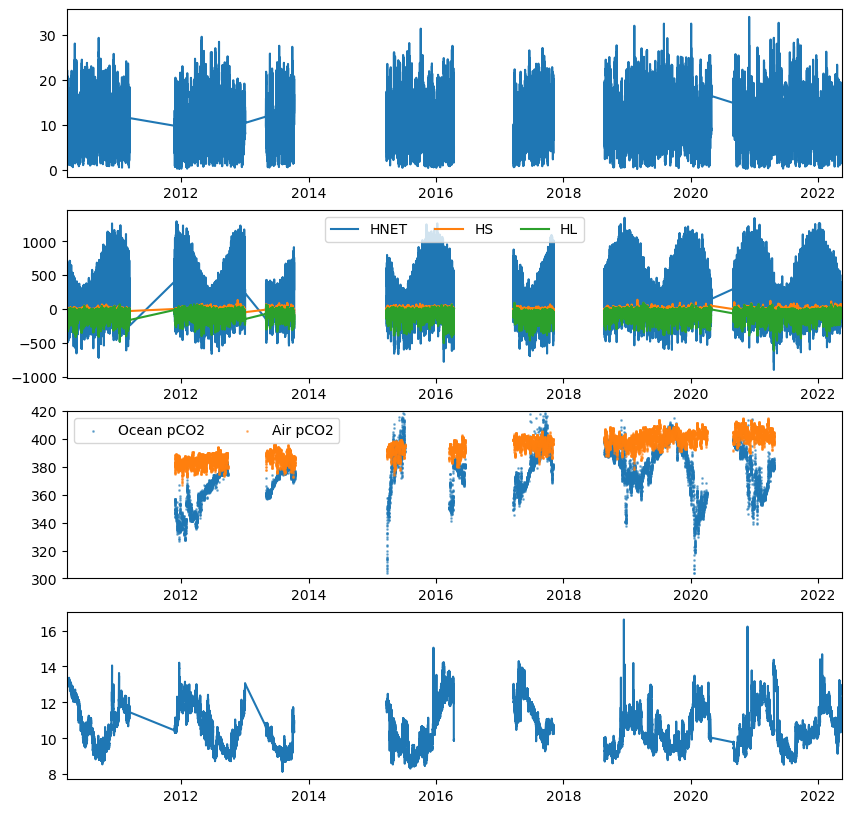

In [140]:
fig, ax = plt.subplots(4, figsize=(10, 10))

ax[0].plot(ds_sofs.TIME, ds_sofs.WSPD10M)

ax[1].plot(ds_sofs.TIME, -ds_sofs.HEAT_NET, label='HNET')

ax[1].plot(ds_sofs.TIME, -ds_sofs.HS, label='HS')
ax[1].plot(ds_sofs.TIME, -ds_sofs.HL, label='HL')

ax[1].legend(ncol=3)

ax[2].scatter(df.Date.astype('datetime64[ns]'), df.pCO2SW_sat_Uatm, s=1, alpha=0.5, label='Ocean pCO2')
ax[2].scatter(df.Date.astype('datetime64[ns]'), df.pCO2Air_sat_Uatm, s=1, alpha=0.5, label='Air pCO2')

ax[2].legend(ncol=2)

ax[2].set_ylim(300, 420)

ax[3].plot(ds_sofs.TIME, ds_sofs.SST)

for a in ax:
    a.set_xlim(pd.to_datetime('2010-03-17'), pd.to_datetime('2022-05-17'))